# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

ModuleNotFoundError: No module named 'mplleaflet'

In [2]:
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165085 entries, 0 to 165084
Data columns (total 4 columns):
ID            165085 non-null object
Date          165085 non-null datetime64[ns]
Element       165085 non-null object
Data_Value    165085 non-null int64
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 5.0+ MB


## Data Transformation for 2004-2015 Record Min and Max

In [3]:
previous_years = range(2005,2015)
include = df[df.apply(lambda x: x['Date'].year in previous_years, axis=1)]
include = include[include.apply(lambda x: (x['Date'].month, x['Date'].day)!=(2,29), axis=1)]

tmin = include[include['Element'] == 'TMIN']
tmax = include[include['Element'] == 'TMAX']

record_min = tmin.groupby(['Date'], sort=False)['Data_Value'].min()
record_max = tmax.groupby(['Date'], sort=False)['Data_Value'].max()
record_min.sort_index(inplace=True)
record_max.sort_index(inplace=True)

record_min_df = record_min.to_frame()
record_max_df = record_max.to_frame()

for rec_df in [record_min_df, record_max_df]:
    year = 2005
    day = 0
    days = []
    for row in rec_df.index:
        if row.year == year:
            day+=1
            days.append(day)
        else:
            day = 1
            year = row.year
            days.append(day)
    rec_df['Days'] = days
    del rec_df.index.name

record_min_by_day = record_min_df.groupby(['Days'], sort=False)['Data_Value'].min()
record_max_by_day = record_max_df.groupby(['Days'], sort=False)['Data_Value'].max()

In [4]:
%matplotlib notebook

In [14]:
orange = (255,71,19)
yellow = (255,206,0)
green = (0,139,92)
dark_blue = (0,104,150)
turq = (0,144,158)
brightblue = (137,219,236)
navy = (0,0,128)
def color_converter(color):
    return tuple(map(lambda x: x/255, color))

## Data Transformation for 2015 Scatter

In [6]:
df_2015 = df[df.apply(lambda row: row['Date'].year==2015, axis=1)]
days_2015 = list(range(1,366,1))
unique_dates = pd.to_datetime(sorted(df_2015['Date'].unique())) 
#need to use pd.to_datetime to convert numpy.datetime64 to pd Timestamp
date_to_day = dict(zip(unique_dates, days_2015))
df_2015['Days'] = df_2015.apply(lambda row: date_to_day[pd.to_datetime(row['Date'])], axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
tmin_2015 = df_2015[df_2015['Element']=='TMIN']
tmax_2015 = df_2015[df_2015['Element']=='TMAX']

min_record_all_time = tmin_2015.merge(record_min_by_day.to_frame().reset_index(), on='Days', how='left')
max_record_all_time = tmax_2015.merge(record_max_by_day.to_frame().reset_index(), on='Days', how='left')

min_record_all_time['Record_breakers'] = min_record_all_time['Data_Value_x']-min_record_all_time['Data_Value_y']
max_record_all_time['Record_breakers'] = max_record_all_time['Data_Value_x']-max_record_all_time['Data_Value_y']

min_record_in_range = min_record_all_time[min_record_all_time['Record_breakers'] >= 0]
min_record_breakers = min_record_all_time[min_record_all_time['Record_breakers'] < 0]
max_record_in_range = max_record_all_time[max_record_all_time['Record_breakers'] <= 0]
max_record_breakers = max_record_all_time[max_record_all_time['Record_breakers'] > 0]

## Chart Plotting

<IPython.core.display.Javascript object>


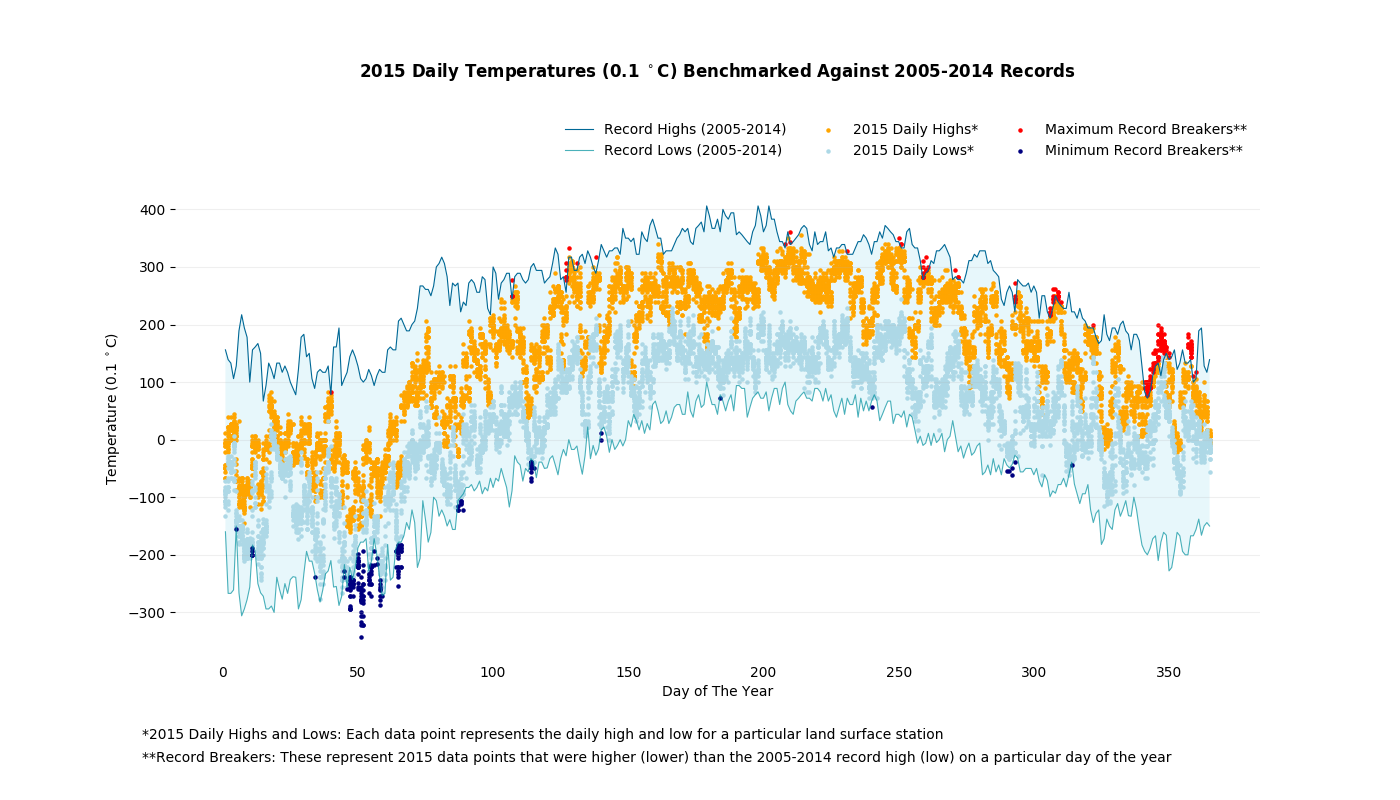

In [32]:
import matplotlib.pyplot as plt
plt.figure()

#Creating Lineplots
plt.plot(record_max_by_day, linewidth=0.8, label='Record Highs (2005-2014)', c=color_converter(dark_blue))
plt.plot(record_min_by_day, linewidth=0.8, label='Record Lows (2005-2014)', c=color_converter(turq), alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(14, 8)
plt.gca().fill_between(record_min_by_day.index,
                      record_min_by_day, record_max_by_day,
                      facecolor=color_converter(brightblue),
                      alpha=0.2)
plt.xlabel('Day of The Year')
plt.ylabel('Temperature (0.1 $^\circ$C)')
plt.title('Daily Inter-Regional Record Highs and Lows (2005-2014)', fontweight='bold')
plt.grid(which='major',axis='y', alpha=0.2)
scale_factor = 1.1
ymin, ymax = plt.ylim()
plt.ylim(ymin * scale_factor, ymax * scale_factor)

ax = plt.gca()
remove_spines = ['right', 'top', 'bottom', 'left']
for spine in remove_spines:
    ax.spines[spine].set_visible(False)

plt.tick_params(bottom='off', labelbottom='on')


#Creating scatterplots
plt.scatter(list(max_record_in_range['Days']), list(max_record_in_range['Data_Value_x']), s= 5, c='orange', label='2015 Daily Highs*')
plt.scatter(list(min_record_in_range['Days']), list(min_record_in_range['Data_Value_x']), s= 5, c='lightblue', label='2015 Daily Lows*')
max_record_breakers_pathcollection=plt.scatter(list(max_record_breakers['Days']), list(max_record_breakers['Data_Value_x']), s= 5, c='red', label='Maximum Record Breakers**')
min_record_breakers_pathcollection=plt.scatter(list(min_record_breakers['Days']), list(min_record_breakers['Data_Value_x']), s= 5, c=color_converter(navy), label='Minimum Record Breakers**')

xmin, xmax = plt.xlim()
plt.legend(loc=1, frameon=False, ncol=3, bbox_to_anchor=(1,1.1)) #bbox_to_anchor moves legend box relative to plot in (x, y) terms
#ncol is the number of columns within the legend box, e.g. if I want it to be horizontal, I have to have ncol = number of legend elements
fig = plt.gcf()
ax = plt.gca()
plt.subplots_adjust(bottom=0.18, top=0.8) #ensures that the x-axis dates dont spill out of the plot
plt.title('2015 Daily Temperatures (0.1 $^\circ$C) Benchmarked Against 2005-2014 Records', y=1.15, fontweight='bold')

#Inserting footnotes
plt.text(-30,-520, '*2015 Daily Highs and Lows: Each data point represents the daily high and low for a particular land surface station')
plt.text(-30, -560, '**Record Breakers: These represent 2015 data points that were higher (lower) than the 2005-2014 record high (low) on a particular day of the year')